# FFT saved file test

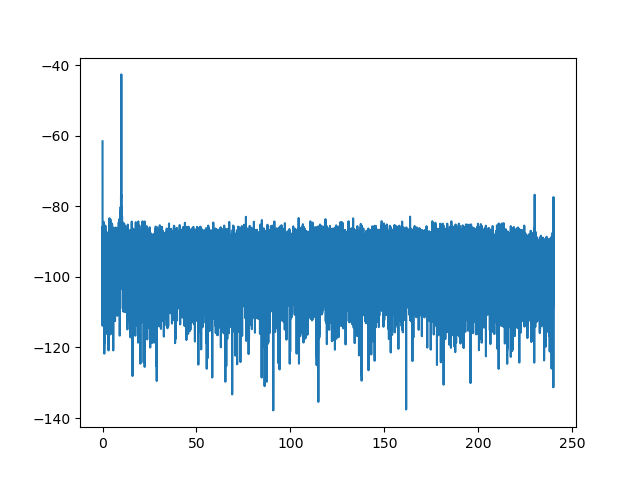

In [22]:
import numpy as np
import h5py as h5
from fft_helper import fft_to_dBm

%matplotlib widget

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

fname = './fft_test/2022-03-04/15/RAW_output1_0.h5'

f = h5.File(fname, 'r')

py = f['power'][...]

st = 1/480.
px = rfftfreq(4096*16, d=st)

plt.plot(px, fft_to_dBm(py[0,...]))
plt.show()


In [4]:
f['power'][...].shape

(64, 32769)